In [1]:
import pandas as pd
import numpy as np

## TODO
### Smooth transitions between weekday and weekend charging profiles

## Constants

In [2]:
WEEKEND_TO_WEEKDAY_CHARGING_RATIO = 0.2

In [3]:
START_DATE = '2019-01-01'

In [4]:
NUM_CHARGING_POINTS = 15

## Import stochastic EV charging profiles
Each row = 5 minutes
Each column = One charging point

In [5]:
df = pd.read_csv('data/Winter_EV_Profiles.csv', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0,0,3,0,0,3,3,0,3,3,...,0,3,0,0,3,3,3,3,3,0
1,0,0,3,0,0,3,3,0,3,3,...,0,3,0,0,3,3,3,3,3,0
2,0,0,3,0,0,3,3,0,3,3,...,0,3,0,0,3,3,3,3,3,0
3,0,0,3,0,0,3,3,0,3,3,...,0,0,0,0,3,3,3,3,3,0
4,0,0,3,0,0,3,3,0,3,3,...,0,0,0,0,3,3,3,3,3,0


## Get mean EV profile per charging point
One day profile

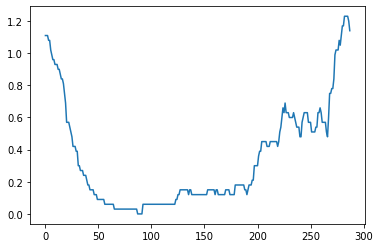

In [6]:
# After Diversity Demand (ADD)
one_day_ADD = df.sum(axis=1) / 100
one_day_ADD.plot()

## Split into weekdays and weekend days

In [ ]:
weekday, weekend = one_day_ADD, one_day_ADD * WEEKEND_TO_WEEKDAY_CHARGING_RATIO

In [ ]:
df = pd.concat([weekday, weekend], axis=1).rename(columns={0:'weekday', 1:'weekend'})
df.plot()

In [ ]:
# Resample to hourly data
df = df.groupby(np.arange(len(df))//(60//5)).mean()
df.plot()

## Build yearly profile per charging point

In [ ]:
start = pd.to_datetime(START_DATE)
end = start + pd.DateOffset(years=1)
days_in_year = pd.date_range(start=start, end=end, freq='1d')

In [ ]:
day_of_week = list(days_in_year.weekday)
working_days = [True if day <= 4 else False for day in day_of_week ]
year = [df.weekday.to_list() if day else df.weekend.to_list() for day in working_days]
year = [hour for day in year for hour in day] # flatten list
year = pd.Series(year)

In [ ]:
year[:24*14].plot()

## Build yearly profile per building with NUM_CHARGING_POINTS

In [ ]:
building_EV_load_one_year = year * NUM_CHARGING_POINTS

In [ ]:
building_EV_load_one_year[:24*14].plot()

## Add datetime index to series

In [ ]:
index = pd.date_range(start=start, end=end, freq='1h')
index[:5]

In [ ]:
building_EV_load_one_year = building_EV_load_one_year[:len(index)]

In [ ]:
len(building_EV_load_one_year) == len(index)

In [ ]:
building_EV_load_one_year.index = index

In [ ]:
building_EV_load_one_year.iloc[:14*24].plot()

# HELPER FUNCTIONS ###################

In [7]:
def _loadprofile(i):
    """
    Switcher function return the sample EV profile file path based on the input value
    Returns: file path
    """
    switcher={
            #Residentail        
            1:'data/Winter_EV_Profiles.csv',
            #Commercial
            2:'data/Commercial.csv',
            #Office
            3:'data/Office.csv',
            #Shopping mall
            4:'data/ShoppingMall.csv',
            #Factory
            5:'data/Factory.csv',
            #Parking
            6:'data/Parking.csv',
         }
    
    return switcher.get(i,"Invalid switch")

In [8]:
def _get_load_profile(building_type,ratio):
    """
    Read the load profile based on the building type and build the profile for a weekday and weekend and convert into hourly data 
    building_type: building type is integer value used by dictionary switcher
    Returns: dataframe with hourly weekday and weekend profile
    """
    
    df = pd.read_csv(_loadprofile(building_type), header=None)
    one_day_ADD = df.sum(axis=1) / 100
    weekday, weekend = one_day_ADD, one_day_ADD * ratio
    df = pd.concat([weekday, weekend], axis=1).rename(columns={0:'weekday', 1:'weekend'})
    df = df.groupby(np.arange(len(df))//(60//5)).mean()
    
    return df

In [9]:
def _build_yearly_profile(df,start_date):
    """
     build the yearly profile for single charging point using a weekday/weekend profile
     df: dataframe input
     start_date: start date for the yearly profile
     Returns:Pandas series for year
    """
    start = pd.to_datetime(start_date)
    end = start + pd.DateOffset(years=1)
    days_in_year = pd.date_range(start=start, end=end, freq='1d')
    day_of_week = list(days_in_year.weekday)
    working_days = [True if day <= 4 else False for day in day_of_week ]
    year = [df.weekday.to_list() if day else df.weekend.to_list() for day in working_days]
    year = [hour for day in year for hour in day] # flatten list
    year = pd.Series(year)
    
    return year

In [10]:
def _build_total_building_load(year,charge_points,start_date):
    """
     build the building profile using yearly profile of charging point
     df: yearly profile of charging point
     charge_points: Number of charge points in a building
     Returns:Pandas data frame yearly load for the building
    """
    start = pd.to_datetime(start_date)
    end = start + pd.DateOffset(years=1)
    
    building_EV_load_one_year = year * charge_points
    index = pd.date_range(start=start, end=end, freq='1h')
    building_EV_load_one_year = building_EV_load_one_year[:len(index)]
    building_EV_load_one_year.index = index
    
    return building_EV_load_one_year

# Main Function

In [25]:
def EV_profile(building_type=None,ratio=0.2,start_date=None,charge_points=15):
    """
    Get the EV load profile up to one year from start date based on the building type Residential/Commercial/Office/Factory/Shopping
    Mall/Park Space and number of charging points

    
    """
    assert start_date is not None or building_type, 'Either start_date or number of charge points must be provided'
    #Get the load profile sample bulidng type
    df = _get_load_profile(1,ratio)
    #Build yearly profile per charging point
    year=_build_yearly_profile(df,start_date)
    #build yearly profile per building
    building_EV_load_one_year = _build_total_building_load(year,charge_points,start_date)
   
    return(pd.DataFrame(building_EV_load_one_year,columns=['kWh']))

# Test function

In [28]:
EV_profile(1,WEEKEND_TO_WEEKDAY_CHARGING_RATIO,START_DATE,NUM_CHARGING_POINTS)

,kwh
2019-01-01 00:00:00,15.2625
2019-01-01 01:00:00,11.0625
2019-01-01 02:00:00,5.5500
2019-01-01 03:00:00,2.6625
2019-01-01 04:00:00,1.2375
...,...
2019-12-31 20:00:00,8.5875
2019-12-31 21:00:00,8.5875
2019-12-31 22:00:00,11.3625
2019-12-31 23:00:00,17.3250
